In [1]:
# Setup
# Import TensorFlow and other necessary libraries:

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Download and explore the dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#After downloading, you should now have a copy of the dataset available.
import pathlib
data_dir = "/content/gdrive/MyDrive/dataset"
data_dir = pathlib.Path(data_dir)

#data_dir1 = "/content/gdrive/MyDrive/dataset/validation"
#data_dir1 = pathlib.Path(data_dir1)

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

#image_count = len(list(data_dir1.glob('*/*.jpeg')))
#print(image_count)

0


In [4]:
#amd = list(data_dir.glob('amd/*'))#amd este o lista de obiecte path
#PIL.Image.open(str(amd[0]))

In [5]:
#PIL.Image.open(str(amd[1]))

In [6]:
#normal = list(data_dir.glob('normal/*'))
#PIL.Image.open(str(normal[0]))

In [7]:
#Un batch este un subset al setului total de date.
#Antrenarea in loturi permite modelului sa invete mai eficient, si de obicei, accelerarea procesului de antrenament.
batch_size = 32
img_height = 512
img_width = 496

In [8]:
from PIL import Image

In [9]:
#functie pentru a incarca si prelucra datele de imagine dintr-un director specificat si pentru a crea un obiect de set de date pentru antrenare.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir /"training",
  validation_split=Image.NONE,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1863 files belonging to 2 classes.


In [10]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir /"validation",
  validation_split=Image.NONE,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 468 files belonging to 2 classes.


In [11]:
#aici putem gasi numele claselor
class_names = train_ds.class_names
print(class_names)

['amd', 'normal']


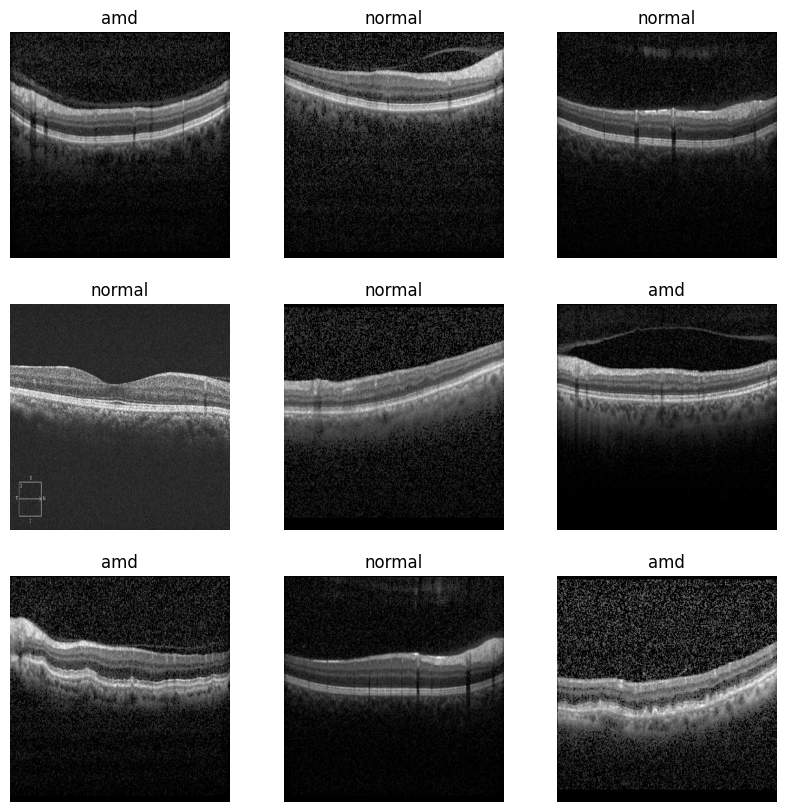

In [12]:
#9 imagini din datasetul training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
####transmitem aceste seturi de date functiei de mai jos pt antrenament mai tarziu####
#(32): Acesta este nr de imagini din lot. In acest caz, sunt 32 de imagini intr-un lot.
#(512 si 496): Reprezinta inaltimea si latimea imaginilor
#(3): Reprezinta nr de canale pt fiecare imagine.
#(32):vector de etichete pentru cele 32 de imagini din lot
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
#Aceste dimensiuni și forme sunt caracteristice datelor de antrenament în învățarea profundă,
#unde un lot de date conține adesea un număr de imagini procesate simultan pentru a îmbunătăți eficiența antrenamentului.

(32, 512, 496, 3)
(32,)


In [14]:
#AUTOTUNE este o constanta care poate fi folosita pt a optimiza performanta
#seturilor de date in timpul executiei
#Dataset.cache():memoreaza datele in memoria RAM sau disc pt a imbunatati performanta
#Se amesteca 1000 de date din dataset training->ordinea datelor din dataset training
#este aleatorizata inainte de fiecare epoca de antrenament
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [15]:
#functie pentru normalizarea valorilor pixelilor intr-o imagine
normalization_layer = layers.Rescaling(1./255)

In [16]:
#folosim functia map pt a aplica normalizarea asupra setului de date; apoi functia lambda primeste un lot de imagini x
#si etichetele y, si aplica normalizarea
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#practic acest cod normalizeaza dataset training si afiseaza valorile minime si maxime
#ale pixelilor primei imagini normalizate pt a verifica daca acestea sunt acum in
#intervalul [0,1]
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# valoarea pixelilor sunt acum `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [17]:
####CREAREA MODELULUI####
#se defineste o arhitectura de retea neuronala convolutionala pt clasificarea imaginilor,
#care incepe cu straturi de convolutie si agregare, urmate de straturi complet conectate
#pt a realiza clasificarea
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
#Modelul incepe cu stratul Rescaling, care normalizeaza valorile pixelilor la intervalul [0,1];
#Urmeaza stratul GlobalAveragePooling2D care reduce dramatic nr de parametri necesari in comparatie
#cu utilizarea unui flatten obișnuit si ajuta la prevenirea overfitting-ului, deoarece reduce
#nr de parametri si contribuie la regularizare
#2 straturi Dense formeaza straturi complet conectate care realizeaza clasificarea

In [18]:
####COMPILAREA SI ANTRENAREA MODELULUI####
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#Modelul este pregatit pentru antrenament, iar configurarile specifice pentru optimizator,
#functia de pierdere si metricile de evaluare sunt stabilite;
#In timpul antrenamentului, aceste configurari vor fi folosite pt a ghida
#procesul de optimizare

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 496, 3)       0         
                                                                 
 global_average_pooling2d (  (None, 3)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 770 (3.01 KB)
Trainable params: 770 (3.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
epochs = 9
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/9
59/59 [==============================] - 557s 4s/step - loss: 0.6837 - accuracy: 0.5695 - val_loss: 0.6802 - val_accuracy: 0.5791
Epoch 2/9
59/59 [==============================] - 9s 149ms/step - loss: 0.6762 - accuracy: 0.5808 - val_loss: 0.6721 - val_accuracy: 0.5791
Epoch 3/9
59/59 [==============================] - 15s 250ms/step - loss: 0.6690 - accuracy: 0.6049 - val_loss: 0.6627 - val_accuracy: 0.5855
Epoch 4/9
59/59 [==============================] - 10s 178ms/step - loss: 0.6621 - accuracy: 0.6146 - val_loss: 0.6529 - val_accuracy: 0.6197
Epoch 5/9
59/59 [==============================] - 11s 185ms/step - loss: 0.6520 - accuracy: 0.6538 - val_loss: 0.6450 - val_accuracy: 0.6410
Epoch 6/9
59/59 [==============================] - 10s 178ms/step - loss: 0.6460 - accuracy: 0.6506 - val_loss: 0.6378 - val_accuracy: 0.6154
Epoch 7/9
59/59 [==============================] - 10s 167ms/step - loss: 0.6398 - accuracy: 0.6463 - val_loss: 0.6329 - val_accuracy: 0.6111
Epoch 8/9

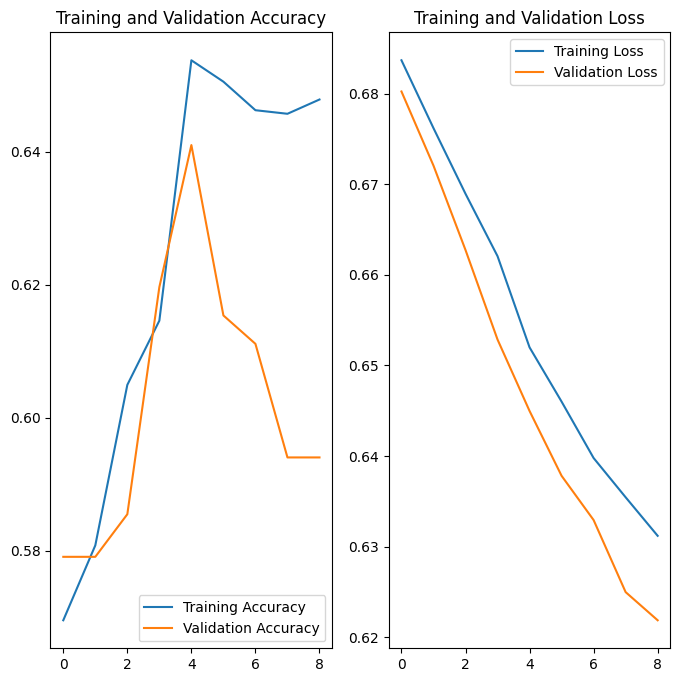

In [21]:
####VIZUALIZAREA REZULTATELOR####
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()